In [1]:
import sys
import pandas as pd
import seaborn as sns
sns.set(style="darkgrid")
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [3]:
sys.version

'3.10.10 (main, Mar 21 2023, 13:41:39) [Clang 14.0.6 ]'

# Loading the data

In [4]:
df = pd.read_parquet("./data/yellow_tripdata_2022-01.parquet")

In [5]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2022-01-01 00:35:40,2022-01-01 00:53:29,2.0,3.80,1.0,N,142,236,1,14.5,3.0,0.5,3.65,0.0,0.3,21.95,2.5,0.0
1,1,2022-01-01 00:33:43,2022-01-01 00:42:07,1.0,2.10,1.0,N,236,42,1,8.0,0.5,0.5,4.00,0.0,0.3,13.30,0.0,0.0
2,2,2022-01-01 00:53:21,2022-01-01 01:02:19,1.0,0.97,1.0,N,166,166,1,7.5,0.5,0.5,1.76,0.0,0.3,10.56,0.0,0.0
3,2,2022-01-01 00:25:21,2022-01-01 00:35:23,1.0,1.09,1.0,N,114,68,2,8.0,0.5,0.5,0.00,0.0,0.3,11.80,2.5,0.0
4,2,2022-01-01 00:36:48,2022-01-01 01:14:20,1.0,4.30,1.0,N,68,163,1,23.5,0.5,0.5,3.00,0.0,0.3,30.30,2.5,0.0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2463931 entries, 0 to 2463930
Data columns (total 19 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[ns]
 2   tpep_dropoff_datetime  datetime64[ns]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int64         
 8   DOLocationID           int64         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  airport_fee           

# Questions

## Q1

In [7]:
# Columns for january data
f"January data has {df.shape[1]} columns"

'January data has 19 columns'

## Q2

In [8]:
# Add duration column
df["duration"] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
# Convert seconds to minutes
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60.0)
# Compute standard deviation
std = df.duration.std()
f"The standard deviation of duration is {std}"

'The standard deviation of duration is 46.44530513776802'

## Q3

In [9]:
# Rows before dropping outliers
total_rows = df.shape[0]
# Dropping trips for whioch duration is smaller than 1 and greater than 60 minutes
df = df[(df.duration >= 1.0) & (df.duration <= 60.0)]
# Rows after dropping outliers
current_rows = df.shape[0]
# Fraction of the records left after you dropping the outliers
remaining_records = current_rows / total_rows * 100.0
f"The fraction of remaining records is {remaining_records} %"

'The fraction of remaining records is 98.27547930522405 %'

## Q4

In [10]:
# Convert PULocationID and DOLocationID columns to object type (str)
categorical = ["PULocationID", "DOLocationID"]
df[categorical] = df[categorical].astype(str)

In [11]:
# Create the train dictionary
train_dict = df[categorical].to_dict(orient="records")

In [12]:
# Printing first 10 entries of the train dictionary
train_dict[:10]

[{'PULocationID': '142', 'DOLocationID': '236'},
 {'PULocationID': '236', 'DOLocationID': '42'},
 {'PULocationID': '166', 'DOLocationID': '166'},
 {'PULocationID': '114', 'DOLocationID': '68'},
 {'PULocationID': '68', 'DOLocationID': '163'},
 {'PULocationID': '138', 'DOLocationID': '161'},
 {'PULocationID': '233', 'DOLocationID': '87'},
 {'PULocationID': '238', 'DOLocationID': '152'},
 {'PULocationID': '166', 'DOLocationID': '236'},
 {'PULocationID': '236', 'DOLocationID': '141'}]

In [13]:
# Create the X_train matrix with a DictVectorizer
dv = DictVectorizer()
X_train = dv.fit_transform(train_dict)

In [14]:
# Getting the dimensions of the X_train matrix
ndims = X_train.shape[1]
f"The X_train matrix has {ndims} dimensions"

'The X_train matrix has 515 dimensions'

In [15]:
# Create the y_train set with duration column
target = "duration"
y_train = df[target].values

## Q5

In [16]:
# Fitting a baseline linear regression with default parameters
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [17]:
# Evaluating the model
y_pred = lr.predict(X_train)
mse = mean_squared_error(y_train, y_pred, squared=False)
f"The rmse on training set is {mse}"

'The rmse on training set is 6.9861908315536585'

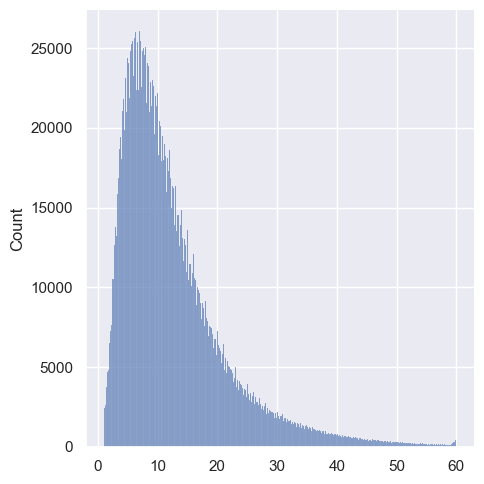

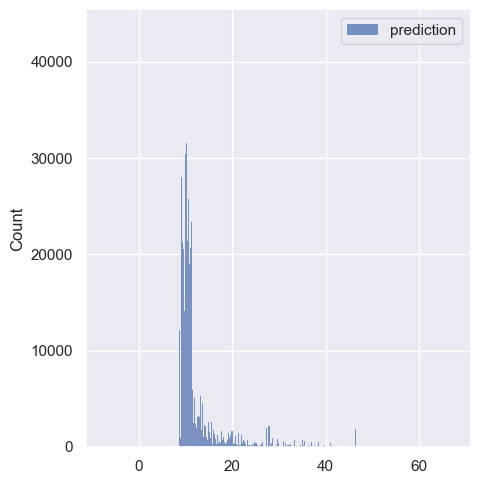

In [18]:
# Plotting the distributions of y_trans and y_pred


sns.displot(y_train, label="actual")
sns.displot(y_pred, label="prediction")

plt.legend()

plt.show()

## Q6

In [19]:
def get_df_from_parquet(filename):
    df = pd.read_parquet(filename)

    df["duration"] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60.0)

    df = df[(df.duration >= 1.0) & (df.duration <= 60.0)]

    categorical = ["PULocationID", "DOLocationID"]
    df[categorical] = df[categorical].astype(str)
    
    return df

In [20]:
# Loading the training and validation set
df_train = get_df_from_parquet("./data/yellow_tripdata_2022-01.parquet")
df_val = get_df_from_parquet("./data/yellow_tripdata_2022-02.parquet")

In [21]:
# Printing the shapes of the training and validation set
df_train.shape, df_val.shape

((2421440, 20), (2918187, 20))

In [22]:
# Creating the feature matrices for the training and validation set
dv = DictVectorizer()
categorical = ["PULocationID", "DOLocationID"]

In [23]:
train_dict = df_train[categorical].to_dict(orient="records")
X_train = dv.fit_transform(train_dict)

In [24]:
val_dict = df_val[categorical].to_dict(orient="records")
X_val = dv.transform(val_dict)

In [25]:
# Create the targets set with duration column
target = "duration"
y_train = df_train[target].values
y_val = df_val[target].values

In [26]:
# Fitting the model on the training set
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [27]:
# Evaluating the model
y_pred = lr.predict(X_train)
mse = mean_squared_error(y_train, y_pred, squared=False)
f"The rmse on training set is {mse}"

'The rmse on training set is 6.9861908315536585'

In [28]:
# Fitting the model on the validation set
lr.fit(X_val, y_val)

LinearRegression()

In [29]:
# Evaluating the model
y_pred = lr.predict(X_val)
mse = mean_squared_error(y_val, y_pred, squared=False)
f"The rmse on validation set is {mse}"

'The rmse on validation set is 7.6395351612958375'